# Cutting plane method aka localisatoin method

Really an alternative to subgradient method. Generally a bit more expensive but in some cases (which?) can work better. Can handle differentiable and non-differentiable problems providing the oracle is implemented to return the subgradient rather than gradient. 

Begin by initalising an LP and solving with CVXPY 

In [6]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt 

def random_piecewise_affine(m=100, n=20):
    """
    f(x) = max(a_1^T x + b_1, ... , a_m^T x + b_m)
    convex, non-differntiable piecewise affine function
    """
    A = np.random.normal(0, 1, size=(m, n))
    b = np.random.uniform(0, 1, size=(m))
    c = -A.T @ np.random.uniform(0, 1, size=(m)) 
    return A, b, c



# ? not actually doing what wnat 
# np.random.seed(1)

# m=100
# n=20

# A, b, c = random_piecewise_affine()

# x = cp.Variable(n)
# obj = cp.Minimize(cp.max(A @ x - b))
# # constraints = [A @ x <= b]
# problem = cp.Problem(obj)
# problem.solve()
# optimal_point = x.value
# optimal_point
# problem.value

Define the subgradient function

## Max volume ellipsoid

Optimisation problem to find largest ellipsoid contained in a polyhedron defined by a number of hyper planes

In [106]:
def plot_hyperplane(ax, a, b):
    """
    doesn't offset the hyperplane from the origin
    """
    ax.arrow(
        0,
        0,
        *a,
        head_width=0.2,
        head_length=0.2,
        length_includes_head=True,
        color="red"
    )
    x1 = np.linspace(-5, 5, 10)
    x2 = (b - x1 * a[0]) / a[1]
    ax.plot(x1, x2)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_aspect("equal")
    ax.grid()

    
def maximum_volume_ellipsoid(a, f):
    """a,f define polyhedron: {z | a.T @ z <= f}
    Given these parameters, find the largest contained polyhedron. (size proportional to det B)

    Args:
        a (list): list of normal vectors
        f (list): list of values 
    """
    a = np.array(a)
    n = len(a[0])
    B = cp.Variable((n,n), PSD=True)
    d = cp.Variable(n)

    contraints = []
    for i in range(len(a)):
        contraints.append(cp.norm(B @ a[i], 2)  + a[i].T @ d <= f[i]) # + polyhedron[i].T @ d 
        
    
    obj = cp.Minimize(-cp.log_det(B))
    problem = cp.Problem(obj, contraints)
    return problem.solve(), B.value, d.value
    
    # B defines the ellisoid, take the center

    
    

Text(0.5, 1.0, 'largest ellipsoid in polyhedron')

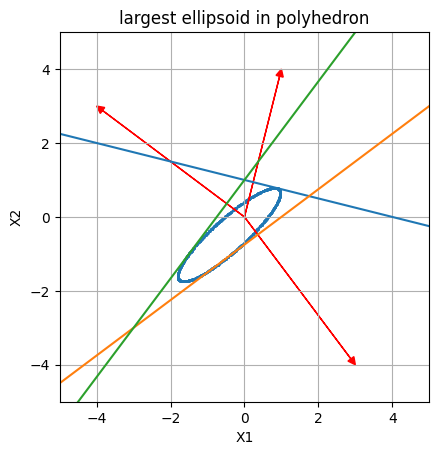

In [123]:
# Init test problem 
A = [[1,4], 
     [3,-4], 
     [-4,3]]
b = [4,3, 3]

# RUn max volume ellpsoid program
value, B, d = maximum_volume_ellipsoid(A, b)

# plot hyperplanes defining polyhedron, then ellipsoid
u = np.random.randn(2, 1000) 
u = u / np.linalg.norm(u, 2, axis=0)
u_ = (B @ u) + np.array([d for _ in range(1000)]).T
fig, ax = plt.subplots()
ax.scatter(*u_ , s=1)
for a_, b_ in zip(A,b):
    plot_hyperplane(ax, a_, b_)
ax.set_title('largest ellipsoid in polyhedron')

## Toy cpm

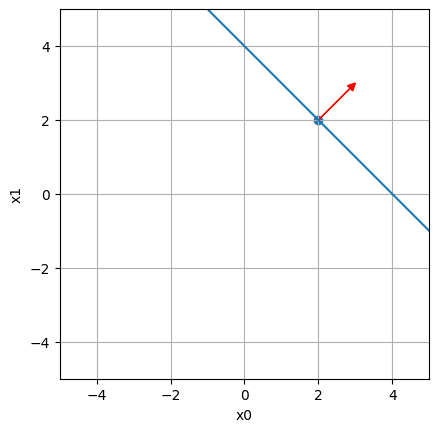

In [94]:
def plot_hyperplane(ax, a, b, offset=np.array([0, 0])):
    """
    doesn't offset the hyperplane from the origin
    """
    ax.arrow(
        *offset,
        *a,
        head_width=0.2,
        head_length=0.2,
        length_includes_head=True,
        color="red"
    )
    x0 = np.linspace(-5, 5, 10) 
    x1 = (-a[0] * (x0 - offset[0])) / a[1] + offset[1]

    ax.plot(x0, x1)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_aspect("equal")
    ax.grid()
    
x_point = np.array([2,2])
g = np.array([1,1])

fig, ax = plt.subplots()
ax.scatter(*x_point)

plot_hyperplane(ax, g, 0, x_point)

## Cutting plane w max ellipsoid

In [66]:
# linear const : [a in Rn, b in Rn] 

import jax 

def objective(x_k):
    return np.max(A @ x_k - b)

objective_grad = jax.grad(objective)

# setup
m=30
n=20
A, b, c = random_piecewise_affine()
polyhedron_a = [] # list of linear constraints. 
polyhedron_f = []
k = 0 
history = []


for i in range(20):
    print(i)
    # choose a point x(k+1) in polydreon. random point for first step
    if polyhedron_a != []:
        value, B, d = maximum_volume_ellipsoid(polyhedron_a, polyhedron_f)
        x_k1 = d
    else:
        x_k1 = np.random.rand(n)
    
    history.append(objective(x_k1))
    
    # query the cutting-plane oracle 
    subgradient = objective_grad(x_k1)
    
    polyhedron_a.append(subgradient + x_k1)
    polyhedron_f.append(0) # 
        
         
        
    k+=1 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


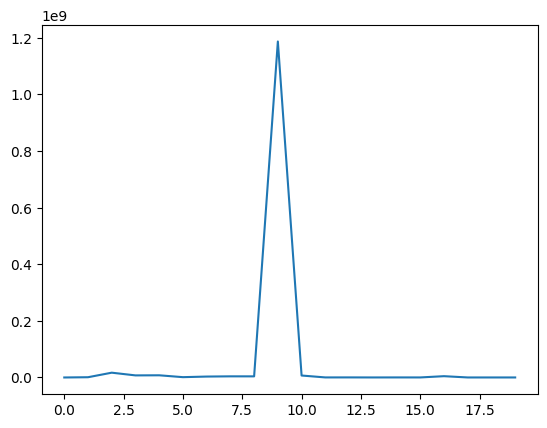

In [67]:
plt.plot(np.arange(20), history)

In [68]:
history

[7.10895159085139,
 878089.26974593,
 16915346.31524779,
 7363238.804314213,
 7707490.851218108,
 1124164.3916930691,
 3232751.894440012,
 4007760.4216649295,
 3938903.9882117445,
 1186259662.347676,
 6915341.5727067925,
 191179.21310229506,
 252849.4510256426,
 90244.03141418345,
 186561.6414726485,
 128552.77890034161,
 4575193.234461371,
 64204.258052146186,
 72708.08606751841,
 62114.96963803458]

# MOre hyperplane

Text(0.5, 1.0, 'largest ellipsoid in polyhedron')

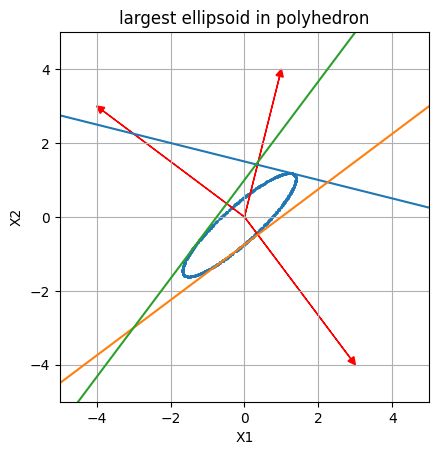

In [128]:
# https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/l_vecs_hyp.html

def plot_hyperplane_x_proj(ax, a, x_proj):
    """
    doesn't offset the hyperplane from the origin
    """
    ax.arrow(
        *x_proj,
        *a,
        head_width=0.2,
        head_length=0.2,
        length_includes_head=True,
        color="red"
    )
    x0 = np.linspace(-5, 5, 10)
    x1 = (-a[0] * (x0 - x_proj[0])) / a[1] + x_proj[1]

    ax.plot(x0, x1)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_aspect("equal")
    ax.grid()

def unit_vector(v):
    return v / np.linalg.norm(v, ord=2)

def plot_hyperplane_ab(ax, a, b):
    """
    doesn't offset the hyperplane from the origin
    """
    a_unit = unit_vector(a)
    x_proj = a_unit * b
    plot_hyperplane_x_proj(ax, a, x_proj)
    
    
# Init test problem 
A = [[1,4], 
     [3,-4], 
     [-4,3]]
b = [6,3, 3]

# RUn max volume ellpsoid program
value, B, d = maximum_volume_ellipsoid(A, b)

# plot hyperplanes defining polyhedron, then ellipsoid
u = np.random.randn(2, 1000) 
u = u / np.linalg.norm(u, 2, axis=0)
u_ = (B @ u) + np.array([d for _ in range(1000)]).T
fig, ax = plt.subplots()
ax.scatter(*u_ , s=1)
for a_, b_ in zip(A,b):
    plot_hyperplane(ax, a_, b_)
    #plot_hyperplane(ax, unit_vector(a_), b_)
ax.set_title('largest ellipsoid in polyhedron')
